### VÍ DỤ 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.svm import SVC

# 1. TẠO DỮ LIỆU
np.random.seed(42)
mean_pos = [2, 2]
mean_neg = [4, 1]
cov_mat = [[0.3, 0.2], [0.2, 0.3]]
num_pts = 10

pos_samples = np.random.multivariate_normal(mean_pos, cov_mat, num_pts)
neg_samples = np.random.multivariate_normal(mean_neg, cov_mat, num_pts)
neg_samples[-1] = [2.7, 2]
pos_samples[-1] = [4.5, 1.2]

X_all = np.hstack((pos_samples.T, neg_samples.T))
y_all = np.hstack((np.ones(num_pts), -np.ones(num_pts)))

# Vẽ dữ liệu phân tách 2 lớp
plt.figure(figsize=(6, 6))
plt.scatter(pos_samples[:, 0], pos_samples[:, 1], color='blue', marker='^', label='Class +1')
plt.scatter(neg_samples[:, 0], neg_samples[:, 1], color='red', marker='o', label='Class -1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Training Data Distribution')
plt.grid(True)
plt.legend()
plt.axis([-1, 6, -1, 6])
plt.tight_layout()
plt.show()

# 2. DUAL SVM BẰNG CVXOPT
V_mat = np.hstack((pos_samples.T, -neg_samples.T))
P = matrix(V_mat.T @ V_mat)
q = matrix(-np.ones(2 * num_pts))
C_val = 100
G = matrix(np.vstack((-np.eye(2 * num_pts), np.eye(2 * num_pts))))
h = matrix(np.vstack((np.zeros(2 * num_pts), C_val * np.ones(2 * num_pts))))
A = matrix(y_all.reshape(1, -1))
b = matrix(np.zeros(1))

solvers.options['show_progress'] = False
solution = solvers.qp(P, q, G, h, A, b)
alphas = np.array(solution['x']).flatten()

support_idx = np.where(alphas > 1e-5)[0]
margin_idx = np.where(alphas < 0.999 * C_val)[0]
support_margin_idx = [i for i in support_idx if i in margin_idx]

X_t = X_all.T
V_sup = V_mat[:, support_idx]
alpha_sup = alphas[support_idx]
y_margin = y_all[support_margin_idx]
X_margin = X_t[support_margin_idx].T

w_dual = V_sup @ alpha_sup
b_dual = np.mean(y_margin - w_dual.T @ X_margin)

print(">> [CVXOPT Dual] w =", w_dual)
print(">> [CVXOPT Dual] b =", b_dual)

# 3. PRIMAL SVM QUA GRADIENT DESCENT
pos_aug = np.vstack((pos_samples.T, np.ones(num_pts)))
neg_aug = np.vstack((neg_samples.T, np.ones(num_pts)))
Z = np.hstack((pos_aug, -neg_aug))

lambda_reg = 1.0 / C_val

def hinge_loss(w):
    margin = w.T @ Z
    loss = np.sum(np.maximum(0, 1 - margin))
    reg = 0.5 * lambda_reg * (np.sum(w * w) - w[-1] ** 2)
    return loss + reg

def hinge_grad(w):
    margin = w.T @ Z
    violators = np.where(margin < 1)[1]
    Z_viol = Z[:, violators]
    grad_val = -np.sum(Z_viol, axis=1, keepdims=True) + lambda_reg * w
    grad_val[-1] -= lambda_reg * w[-1]
    return grad_val

def gradient_descent(w_init, lr):
    w = w_init.copy()
    for _ in range(100000):
        g = hinge_grad(w)
        w -= lr * g
        if np.linalg.norm(g) < 1e-5:
            break
    return w

w_init = np.random.randn(Z.shape[0], 1)
w_opt = gradient_descent(w_init, 0.001)

w_primal = w_opt[:-1].flatten()
b_primal = w_opt[-1, 0]

print(">> [Gradient Descent] w =", w_primal)
print(">> [Gradient Descent] b =", b_primal)

# 4. SVM THƯ VIỆN SKLEARN
X_skl = X_all.T
y_skl = y_all

svm_model = SVC(kernel='linear', C=100)
svm_model.fit(X_skl, y_skl)

print(">> [Sklearn SVM] w =", svm_model.coef_.flatten())
print(">> [Sklearn SVM] b =", svm_model.intercept_[0])


ModuleNotFoundError: No module named 'cvxopt'

### THỰC HÀNH 1

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from cvxopt import matrix, solvers

# ===== Tạo dữ liệu =====
def generate_data():
    np.random.seed(21)
    means = [[2, 2], [4, 1]]
    cov = [[.3, .2], [.2, .3]]
    N = 10
    X0 = np.random.multivariate_normal(means[0], cov, N)
    X1 = np.random.multivariate_normal(means[1], cov, N)
    X1[-1] = [2.7, 2]
    X0[-1] = [4.5, 1.2]
    X = np.concatenate((X0.T, X1.T), axis=1)
    y = np.concatenate((np.ones((1, N)), -np.ones((1, N))), axis=1)
    return X, y.flatten(), X0, X1

In [9]:
# ===== Dự đoán với w, b =====
def predict(X, w, b):
    y_score = w.T @ X + b
    return np.sign(y_score).flatten()

In [10]:
# ===== Tính accuracy và confusion matrix =====
def evaluate(y_true, y_pred, title=""):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[1, -1])
    print(f"{title} Accuracy: {acc:.4f}")
    print(f"{title} Confusion Matrix:\n{cm}")
    return acc, cm

In [11]:
# ===== Chạy cả 3 phương pháp với từng giá trị C =====
def run_all_methods(C_val):
    print(f"\n======== C = {C_val} ========")
    X, y, X0, X1 = generate_data()
    XT = X.T
    N = len(y) // 2
    V = np.concatenate((X0.T, -X1.T), axis=1)

    ## --- CÁCH 1: CVXOPT (DUAL) ---
    K = matrix(V.T @ V)
    q = matrix(-np.ones((2 * N, 1)))
    G = matrix(np.vstack((-np.eye(2 * N), np.eye(2 * N))))
    h = matrix(np.vstack((np.zeros((2 * N, 1)), C_val * np.ones((2 * N, 1)))))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros((1, 1)))
    solvers.options['show_progress'] = False
    sol = solvers.qp(K, q, G, h, A, b)
    l = np.array(sol['x'])
    S = np.where(l > 1e-5)[0]
    S2 = np.where(l < .999 * C_val)[0]
    M = [val for val in S if val in S2]
    VS = V[:, S]
    lS = l[S]
    XM = XT[M].T
    yM = y[M]
    w_dual = VS @ lS
    b_dual = np.mean(yM - (w_dual.T @ XM).flatten())
    print("[CVXOPT] w:", w_dual.T)
    print("[CVXOPT] b:", b_dual)
    y_pred_cvx = predict(X, w_dual, b_dual)
    evaluate(y, y_pred_cvx, "[CVXOPT]")
    ## --- CÁCH 2: GRADIENT DESCENT (PRIMAL) ---
    X0_bar = np.vstack((X0.T, np.ones((1, N))))
    X1_bar = np.vstack((X1.T, np.ones((1, N))))
    Z = np.hstack((X0_bar, -X1_bar))
    lam = 1.0 / C_val

    def cost(w):
        u = w.T @ Z
        return (np.sum(np.maximum(0, 1 - u)) + 0.5 * lam * np.sum(w * w)) - 0.5 * lam * w[-1]**2

    def grad(w):
        u = w.T @ Z
        H = np.where(u < 1)[1]
        ZS = Z[:, H]
        g = (-np.sum(ZS, axis=1, keepdims=True) + lam * w)
        g[-1] -= lam * w[-1]
        return g

    def grad_descent(w0, eta):
        w = w0
        for it in range(100000):
            g = grad(w)
            w -= eta * g
            if np.linalg.norm(g) < 1e-5:
                break
        return w
    
    w0 = np.random.randn(Z.shape[0], 1)
    w_opt = grad_descent(w0, 0.001)
    w_hinge = w_opt[:-1]
    b_hinge = w_opt[-1][0]
    print("[GRAD DESCENT] w:", w_hinge.T)
    print("[GRAD DESCENT] b:", b_hinge)
    y_pred_hinge = predict(X, w_hinge, b_hinge)
    evaluate(y, y_pred_hinge, "[GRAD DESCENT]")

    ## --- CÁCH 3: SKLEARN ---
    clf = SVC(kernel='linear', C=C_val)
    clf.fit(X.T, y)
    w_skl = clf.coef_.reshape(-1, 1)
    b_skl = clf.intercept_[0]
    print("[SKLEARN] w:", w_skl.T)
    print("[SKLEARN] b:", b_skl)
    y_pred_skl = predict(X, w_skl, b_skl)
    evaluate(y, y_pred_skl, "[SKLEARN]")

In [12]:
# ===== CHẠY VỚI C = 1000, 200, 10, 0.5 =====
for C_val in [1000, 200, 10, 0.5]:
    run_all_methods(C_val)


======== C = 1000 ========
[CVXOPT] w: [[-1.06641741  1.01378006]]
[CVXOPT] b: 1.7287294219398297
[CVXOPT] Accuracy: 0.9000
[CVXOPT] Confusion Matrix:
[[9 1]
 [1 9]]
[GRAD DESCENT] w: [[-1.07037607  0.99822887]]
[GRAD DESCENT] b: 1.681699167110982
[GRAD DESCENT] Accuracy: 0.9000
[GRAD DESCENT] Confusion Matrix:
[[9 1]
 [1 9]]
[SKLEARN] w: [[-1.06653242  1.01479775]]
[SKLEARN] b: 1.6617630411834636
[SKLEARN] Accuracy: 0.9000
[SKLEARN] Confusion Matrix:
[[9 1]
 [1 9]]

======== C = 200 ========
[CVXOPT] w: [[-1.06639664  1.01377874]]
[CVXOPT] b: 1.6623680064193869
[CVXOPT] Accuracy: 0.9000
[CVXOPT] Confusion Matrix:
[[9 1]
 [1 9]]
[GRAD DESCENT] w: [[-1.06738655  0.99966439]]
[GRAD DESCENT] b: 1.6826991671108582
[GRAD DESCENT] Accuracy: 0.9000
[GRAD DESCENT] Confusion Matrix:
[[9 1]
 [1 9]]
[SKLEARN] w: [[-1.06696752  1.01310859]]
[SKLEARN] b: 1.6645414911482976
[SKLEARN] Accuracy: 0.9000
[SKLEARN] Confusion Matrix:
[[9 1]
 [1 9]]

======== C = 10 ========
[CVXOPT] w: [[-1.10104703  0.5

### THỰC HÀNH 2

In [13]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import seaborn as sns

# ===== 1. Đọc dữ liệu ung thư vú =====
cancer_data = datasets.load_breast_cancer()
X = cancer_data.data
y = cancer_data.target  # benign=1, malignant=0 → đổi về {-1, 1}
y = 2 * y - 1  # chuyển về [-1, 1]

In [14]:
# ===== 2. Tách và chuẩn hóa dữ liệu =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=109, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


>> [SKLEARN SVC] Accuracy: 0.9590643274853801
              precision    recall  f1-score   support

   Malignant       0.97      0.92      0.94        64
      Benign       0.95      0.98      0.97       107

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



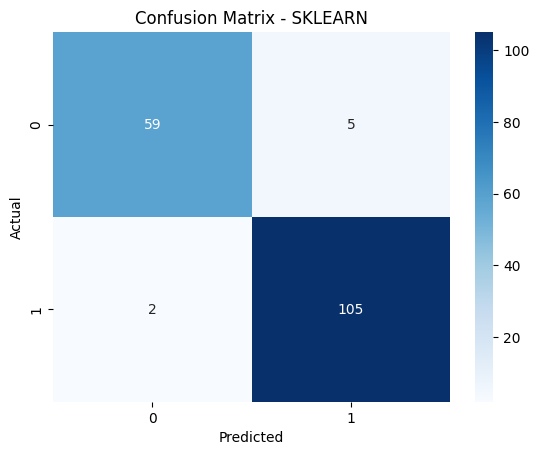

w: [[-0.36827756 -0.65242025 -0.35026902 -0.44289825  0.04049432  0.6843694
  -0.95142001 -0.5021383  -0.18588593  0.10754847 -0.64322619  0.46810073
  -0.52998244 -0.74617396 -0.04473395  0.20658666  0.07057163 -0.35758558
   0.19241721  0.57962561 -0.33649293 -0.58284039 -0.17749446 -0.5975978
  -0.62434894  0.59614248 -1.11265748 -0.04468698 -0.58088047 -0.35880549]]
b: [0.24149584]


In [15]:
# ===== 3. PHƯƠNG PHÁP 1: Sklearn SVC =====
clf = SVC(kernel='linear', C=1.0)
clf.fit(X_train, y_train)
y_pred_skl = clf.predict(X_test)

print("\n>> [SKLEARN SVC] Accuracy:", accuracy_score(y_test, y_pred_skl))
print(classification_report(y_test, y_pred_skl, target_names=['Malignant', 'Benign']))
sns.heatmap(confusion_matrix(y_test, y_pred_skl), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SKLEARN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("w:", clf.coef_)
print("b:", clf.intercept_)


>> [CVXOPT] Accuracy: 0.9766081871345029
              precision    recall  f1-score   support

   Malignant       0.97      0.97      0.97        64
      Benign       0.98      0.98      0.98       107

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



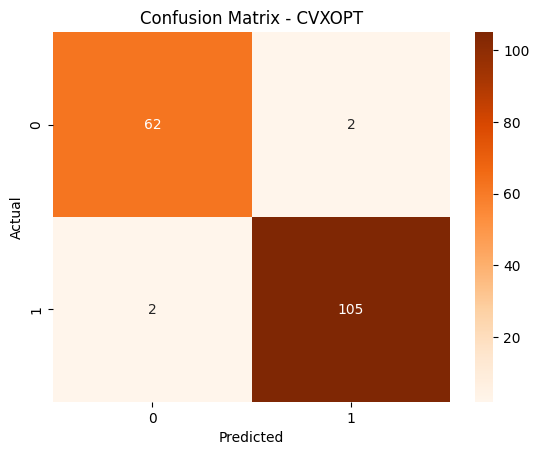

w: [[-0.36830433 -0.65219058 -0.35041773 -0.44299543  0.04095088  0.68392586
  -0.95178114 -0.50186045 -0.18576668  0.10765981 -0.64298465  0.4679733
  -0.53047865 -0.74624216 -0.04475064  0.20678196  0.07068554 -0.35770313
   0.1922035   0.5794822  -0.33633002 -0.58282021 -0.17780081 -0.59769203
  -0.62484173  0.59613508 -1.11212635 -0.04485153 -0.58079151 -0.35885464]]
b: -0.04997320616240046


In [19]:
# ===== 4. PHƯƠNG PHÁP 2: CVXOPT DUAL SVM =====
def train_cvxopt(X, y, C=1.0):
    N, d = X.shape
    y = y.reshape(-1, 1) * 1.0
    K = np.dot(X, X.T)
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones((N, 1)))
    G_std = np.diag(-np.ones(N))
    h_std = np.zeros(N)
    G_slack = np.identity(N)
    h_slack = C * np.ones(N)
    G = matrix(np.vstack((G_std, G_slack)))
    h = matrix(np.hstack((h_std, h_slack)))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alpha = np.ravel(sol['x'])

    sv = alpha > 1e-5
    alpha_sv = alpha[sv]
    X_sv = X[sv]
    y_sv = y[sv]

    # ➤ Fix shape here:
    w = ((alpha_sv * y_sv.ravel()).reshape(-1, 1) * X_sv).sum(axis=0).reshape(-1, 1)
    b = np.mean(y_sv - X_sv @ w)

    return w, b


w_dual, b_dual = train_cvxopt(X_train, y_train)
y_score = X_test @ w_dual + b_dual
y_pred_cvx = np.sign(y_score).flatten()

print("\n>> [CVXOPT] Accuracy:", accuracy_score(y_test, y_pred_cvx))
print(classification_report(y_test, y_pred_cvx, target_names=['Malignant', 'Benign']))
sns.heatmap(confusion_matrix(y_test, y_pred_cvx), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - CVXOPT")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("w:", w_dual.T)
print("b:", b_dual)


>> [GRAD DESCENT] Accuracy: 0.9590643274853801
              precision    recall  f1-score   support

   Malignant       0.97      0.92      0.94        64
      Benign       0.95      0.98      0.97       107

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



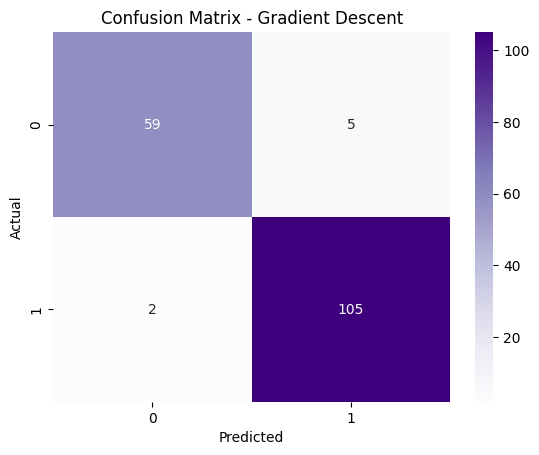

w: [[-0.36094604 -0.65507237 -0.34034192 -0.43436716  0.02700179  0.67872175
  -0.93502666 -0.49986085 -0.18192535  0.107067   -0.64974144  0.46431194
  -0.52475793 -0.73698556 -0.03432524  0.23359678  0.07475426 -0.37998007
   0.17410772  0.57183342 -0.35757654 -0.58353929 -0.18407493 -0.60297251
  -0.6168124   0.58487786 -1.13656584 -0.05493268 -0.58433436 -0.36768717]]
b: 0.23847350247659754


In [21]:
# ===== 5. PHƯƠNG PHÁP 3: Gradient Descent PRIMAL SVM =====
lam = 1.0  # lam = 1/C
X_bar = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # thêm bias
Z = X_bar * y_train.reshape(-1, 1)

def cost(w):
    u = Z @ w
    return np.sum(np.maximum(0, 1 - u)) + 0.5 * lam * np.sum(w[:-1] ** 2)

def grad(w):
    u = Z @ w                                # shape: (N, 1)
    mask = u < 1                             # shape: (N, 1)
    ZS = Z[mask.ravel()]                     # shape: (#vi phạm, d+1)
    dL = -np.sum(ZS, axis=0).reshape(-1, 1)  # shape: (d+1, 1)
    dL[:-1] += lam * w[:-1]                  # không regularize bias
    return dL


def grad_descent(w0, eta=0.001):
    w = w0
    for i in range(100000):
        g = grad(w)
        w -= eta * g
        if np.linalg.norm(g) < 1e-5:
            break
    return w

w0 = np.random.randn(X_train.shape[1] + 1, 1)
w_primal = grad_descent(w0)
w_gd = w_primal[:-1]
b_gd = w_primal[-1]

y_score = X_test @ w_gd + b_gd
y_pred_gd = np.sign(y_score).flatten()

print("\n>> [GRAD DESCENT] Accuracy:", accuracy_score(y_test, y_pred_gd))
print(classification_report(y_test, y_pred_gd, target_names=['Malignant', 'Benign']))
sns.heatmap(confusion_matrix(y_test, y_pred_gd), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Gradient Descent")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("w:", w_gd.T)
print("b:", b_gd[0])

### VÍ DỤ 3

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ===== 1. Đọc dữ liệu từ file local =====
file_path = r"C:\Users\PC\học python\NewProject\MachineLearning\Ex7\spambase\spambase.data"
df = pd.read_csv(file_path, header=None)

In [23]:
# ===== 2. Phân chia X và y, đổi nhãn thành -1, 1 =====
X = df.iloc[:, :-1].values       # 57 đặc trưng
y = df.iloc[:, -1].values        # nhãn 0 (non-spam), 1 (spam)
y = np.where(y == 1, 1, -1)      # đổi về {-1, 1}

In [24]:
# ===== 3. Chia train/test và chuẩn hóa dữ liệu =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
# ===== 4. Huấn luyện với SVM (kernel tuyến tính) =====
clf = SVC(kernel='linear', C=1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [26]:
# ===== 5. Đánh giá =====
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-spam", "Spam"]))


✅ Accuracy: 0.9290

Classification Report:
              precision    recall  f1-score   support

    Non-spam       0.94      0.95      0.94       837
        Spam       0.92      0.90      0.91       544

    accuracy                           0.93      1381
   macro avg       0.93      0.92      0.93      1381
weighted avg       0.93      0.93      0.93      1381



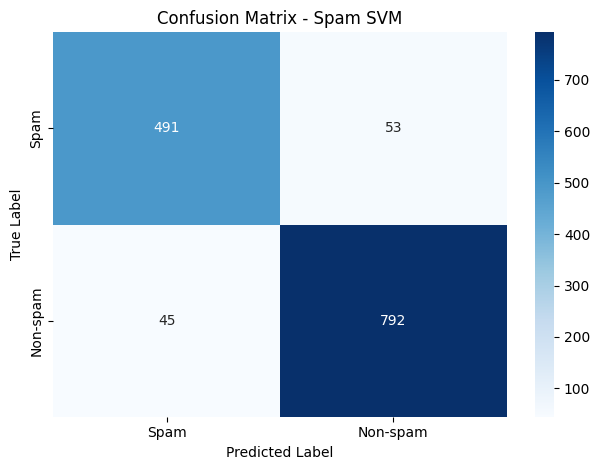

In [27]:
# ===== 6. Ma trận nhầm lẫn =====
cm = confusion_matrix(y_test, y_pred, labels=[1, -1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Spam", "Non-spam"], yticklabels=["Spam", "Non-spam"])
plt.title("Confusion Matrix - Spam SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [28]:
# ===== 7. In trọng số nếu muốn (tùy chọn) =====
print("Trọng số w:", clf.coef_)
print("Bias b:", clf.intercept_)

Trọng số w: [[-1.47888424e-01  8.82208999e-04  9.46730939e-03  1.01533733e+00
   3.13384140e-01  1.78396265e-01  5.81101891e-01  1.60984171e-01
   1.85362859e-01  1.91144948e-01 -3.49555756e-02 -1.45482205e-01
  -2.96056224e-02 -3.87592549e-03  1.63049776e-01  5.78460096e-01
   2.99989842e-01  8.53657802e-02  2.81542026e-02  1.53951634e-01
   1.90234866e-01  1.92769060e-01  4.86677208e-01  1.35085011e-01
  -1.69619347e+00 -6.63483701e-01 -2.98850503e+00  1.49648925e-01
  -7.83726638e-01  3.23635784e-02 -9.31765398e-01  4.66975091e-01
  -1.72995680e-01 -1.22537409e+00 -1.04808401e+00  2.63832502e-01
  -1.51891797e-01 -6.84302602e-02 -5.43284476e-02 -3.79418198e-03
  -1.15970043e+00 -7.75940803e-01 -1.08068259e-01 -4.02500475e-01
  -4.69943223e-01 -1.00406105e+00 -1.14055754e-02 -6.50518751e-01
  -2.35876540e-01 -4.56112785e-02 -4.64630077e-02  3.94170961e-01
   9.90481704e-01  3.76412453e-01  1.11964103e+00  1.24570296e+00
   2.12134486e-01]]
Bias b: [-1.76973244]


### BÀI TẬP

In [29]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Load dữ liệu mẫu ===
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target

# (tuỳ chọn) chuyển y từ 0/1 → -1/1 cho SVM chuẩn
y = np.where(y == 0, -1, 1)


In [30]:
# === 2. Chia train/test: 70% train, 30% test ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [31]:
# === 3. Chuẩn hóa dữ liệu ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
# === 4. Tạo mô hình SVM Soft-Margin với C tùy chọn ===
C_val = 1.0  # Bạn có thể thử các giá trị khác như 0.1, 10, 100...
clf = SVC(kernel='linear', C=C_val)
clf.fit(X_train, y_train)

SVC(kernel='linear')

🎯 Đánh giá trên tập TRAIN:

✅ Accuracy: 0.9899
              precision    recall  f1-score   support

   Malignant       0.99      0.98      0.99       148
      Benign       0.99      1.00      0.99       250

    accuracy                           0.99       398
   macro avg       0.99      0.99      0.99       398
weighted avg       0.99      0.99      0.99       398



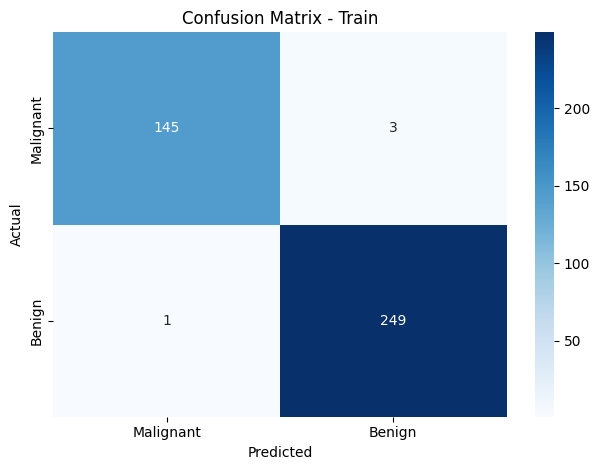

🎯 Đánh giá trên tập TEST:

✅ Accuracy: 0.9825
              precision    recall  f1-score   support

   Malignant       0.98      0.97      0.98        64
      Benign       0.98      0.99      0.99       107

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



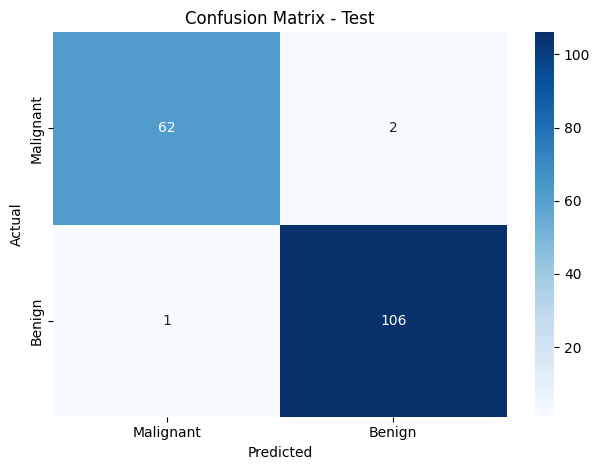

In [33]:
# === 5. Dự đoán và đánh giá ===
def evaluate(y_true, y_pred, title="Confusion Matrix"):
    acc = accuracy_score(y_true, y_pred)
    print(f"\n✅ Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=["Malignant", "Benign"]))
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Malignant", "Benign"], yticklabels=["Malignant", "Benign"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

print("🎯 Đánh giá trên tập TRAIN:")
y_train_pred = clf.predict(X_train)
evaluate(y_train, y_train_pred, title="Confusion Matrix - Train")

print("🎯 Đánh giá trên tập TEST:")
y_test_pred = clf.predict(X_test)
evaluate(y_test, y_test_pred, title="Confusion Matrix - Test")

### VÍ DỤ 5

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

# Đọc dữ liệu từ file CSV
df = pd.read_csv("C:\\Users\\PC\\học python\\NewProject\\MachineLearning\\Ex7\\archive (1)\Admission_Predict_Ver1.1.csv")

<>:9: SyntaxWarning: invalid escape sequence '\A'
<>:9: SyntaxWarning: invalid escape sequence '\A'
C:\Users\PC\AppData\Local\Temp\ipykernel_1996\2022930786.py:9: SyntaxWarning: invalid escape sequence '\A'
  df = pd.read_csv("C:\\Users\\PC\\học python\\NewProject\\MachineLearning\\Ex7\\archive (1)\Admission_Predict_Ver1.1.csv")


In [36]:
# Tiền xử lý dữ liệu
df.drop("Serial No.", axis=1, inplace=True)
# Tạo nhãn nhị phân: 1 nếu Chance of Admit >= 0.8, ngược lại là 0
df['Admitted'] = (df['Chance of Admit '] >= 0.8).astype(int)
X = df.drop(['Chance of Admit ', 'Admitted'], axis=1)
y = df['Admitted']


In [37]:
# Chia dữ liệu thành train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
# ----------- SVM -----------
svm = SVC(kernel='linear', C=1.0)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)


In [39]:
# ----------- Logistic Regression -----------
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)


In [40]:
# ----------- Đánh giá kết quả -----------
print("SVM Train Accuracy:", accuracy_score(y_train, svm.predict(X_train)))
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

print("\nLogistic Regression Train Accuracy:", accuracy_score(y_train, logreg.predict(X_train)))
print("Logistic Regression Test Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))

SVM Train Accuracy: 0.92
SVM Test Accuracy: 0.9533333333333334
SVM Confusion Matrix:
 [[101   6]
 [  1  42]]

Logistic Regression Train Accuracy: 0.92
Logistic Regression Test Accuracy: 0.9533333333333334
Logistic Regression Confusion Matrix:
 [[101   6]
 [  1  42]]
